## Six-bar Mechanism Balancing

In [2]:
from BetaShF import ShF
from BetaShM import ShM 
import numpy as np 
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

### Contraints

$-0.16m <= x_{cn},y_{cn} <= 0.16m$

$0.005m <= t_{cn} <= 0.04m$

### Objective Function

In [3]:
def objective_function(s, ShF, ShM): #c is a constant that distributes the weight among the functions.
    c = 0.5
    return c*ShF(s) + c*ShM(s)

### Differential Evolution

In [4]:
# Bounds for each variable
nVar = 5
bounds = []
for i in range(1,nVar*3+1):
    if(i%3==0): bounds.append([0.005,0.04])
    else: bounds.append([-0.16, 0.16])
#print(bounds)


In [5]:
it = 5
n = 100
sols = np.zeros((n, 2))
best, bestSol = 10, None
for i in range(n):
    r = differential_evolution(objective_function, bounds, args=(ShF, ShM), maxiter=it)
    sols[i][0], sols[i][1] = ShF([*r['x']]), ShM([*r['x']])
    if r['fun'] < best:
        best = r['fun']
        bestSol = r

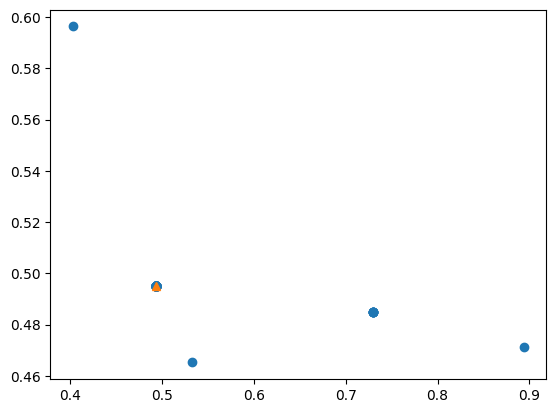

In [ ]:
np.savetxt('Solutions.txt', sols, delimiter=', ')   # X is an array

plt.plot(sols[:, 0], sols[:, 1], 'o')
plt.plot(ShF([*bestSol['x']]), ShM([*bestSol['x']]), '^')

In [ ]:
np.sqrt(best)

0.7031525142439927

In [ ]:
# bestSol
print(bestSol.x)

[-2.53960013e-02 -3.41818386e-02  4.00000000e-02 -7.23789412e-02
 -7.65623355e-03  3.99733778e-02 -5.78430390e-02  6.23264786e-03
  4.00000000e-02 -5.37652112e-08 -1.55358374e-08  5.00000000e-03
  2.03388323e-07 -2.73487187e-07  5.00000000e-03]


### Gradient Descent

In [ ]:
eps = 1e-5
def Vf(X,f): # Gradient Vector using finite difference
    n = len(X)
    G = np.zeros((n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        G[i] = (f(X+incX, ShF, ShM)-f(X, ShF, ShM))/eps
        incX[i] = 0
    return G

def VfTd(X,d,f): # Gradient multiplied by a vector
    return (f(X+eps*d, ShF, ShM)-f(X, ShF, ShM))/eps

def V2f(X,f): # Hessian with finite difference
    n = len(X)
    H = np.zeros((n,n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        H[:,i] = (Vf(X+incX,f)-Vf(X,f))/eps
        incX[i] = 0
    return H

def V2fTd(X,d,f): # Hessian multiplied by a vector
    return (Vf(X+eps*d,f)-Vf(X,f))/eps
    
X = np.array([2,3])
d = np.array([5,1])
print('f:',objective_function(X, ShF, ShM))
print('Vf:',Vf(X,objective_function))
print('V2f:',V2f(X,objective_function))
print('VfTd:',VfTd(X,d,objective_function))
print('V2fTd:',V2fTd(X,d,objective_function))

NameError: name 'np' is not defined

In [ ]:
def gradient_descent(x):
    max_iter = 3
    k=0
    while(k < max_iter and np.linalg.norm(Vf(x)) < eps ):
        # Calculate step size a_k
        a_k = (-VfTd(x,d,objective_function) * d ) / V2f(x) * d # P = d
        # Calculate the direction P_k
        d = (-Vf(x, objective_function))/np.linalg.norm(Vf(x, objective_function))
        x = x + a_k*d
        k+=1
    return x

In [ ]:
max_iter = 10
alpha = 0.1

gradient_descent(bestSol.x)